# Testing MPO

In [10]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Make oracles.

In [2]:
import os

dockstring_dir = f'{path}/dockstring_targets/'
files = os.listdir(dockstring_dir)
configs = sorted([f for f in files if 'conf' in f])
targets = sorted([f for f in files if 'target' in f])

idx = 0
with open(dockstring_dir + configs[idx], 'r') as f:
    config_ = f.readlines()
    config_ = [c.replace('\n', '') for c in config_]
    config_ = [c.split(' = ') for c in config_ if c]
    config_ = {c[0]: float(c[1]) for c in config_}

target = targets[idx]
name = target.split('_')[0]

config_.update({
    'size_x': 22.5,
    'size_y': 22.5,
    'size_z': 22.5,
})

from dgym.envs.oracle import DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'search_mode': 'detailed',
    'scoring': 'vina',
    'seed': 5,
    **config_
}

docking_oracle = DockingOracle(
    f'{name} affinity',
    receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
    config=config
)
log_P_oracle = RDKitOracle('MolLogP')
log_S_oracle = CatBoostOracle('Log S', path='../../dgym-data/models/aqsolcb.model')

# create evaluators
docking_utility_function = ClassicUtilityFunction(
    docking_oracle,
    ideal=(9.5, 13),
    acceptable=(9, 13)
)

log_P_utility_function = ClassicUtilityFunction(
    log_P_oracle,
    ideal=(0.5, 1.85),
    acceptable=(-0.5, 3.5)
)

log_S_utility_function = ClassicUtilityFunction(
    log_S_oracle,
    ideal=(-1, 1),
    acceptable=(-4, 1)
)

assays = [
    docking_oracle,
    log_P_oracle,
    log_S_oracle
]

utility_functions = [
    docking_utility_function,
    log_P_utility_function,
    log_S_utility_function
]

Instantiate designer.

In [3]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [150]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
initial_library = dg.MoleculeCollection(initial_molecules)
initial_library.update_annotations()
library = initial_library

Prepare MPO ranking function.

In [151]:
import numpy as np
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def rank_molecules(utility):
    
    costs = -utility

    # Multi-dimensional non-dominated fusion sort
    costs = np.nan_to_num(costs, 1e2)
    nds, nds_ranks = NonDominatedSorting().do(
        costs, return_rank=True, only_non_dominated_front=False)
    penalty_sums = np.sum(costs, axis=1)
    fused_ranks = np.lexsort([penalty_sums, nds_ranks])
    
    return fused_ranks.tolist()

In [289]:
from dgym.envs.utility import MultipleUtilityFunction

multiple_utility_function = MultipleUtilityFunction(
    utility_functions, weights=[0.6, 0.2, 0.2]
)

In [323]:
multiple_utility_function(
    deck, method='min'
)

[-15.831973199621839,
 -12.27487341825704,
 -17.08754881778691,
 -15.135048183539244,
 -17.873136171241388,
 -15.338026563452729,
 -24.135032314230433,
 -32.05182384753908,
 -14.052876803082674,
 -12.641178828655097,
 -17.255618062250637,
 -30.41404872369453,
 -18.705753791213205,
 -19.819354236941567,
 -7.063071498844025,
 -11.363260479858768,
 -17.848062584967735,
 -11.906157928931558,
 -15.765456392388565,
 -20.08853311222413,
 -5.8784014357443874,
 -9.851622402621198,
 -16.10015215496709,
 -16.156877547268973,
 -27.46907529062438,
 -17.262477343865513,
 -6.4753345476878685,
 -6.511056891818391,
 -71.70048053595949,
 -13.052462313157259,
 -16.13009967052711,
 -2.3429342161176145,
 -17.432877184421258,
 -20.66598004089399,
 -22.982270542687072,
 -3.8104875086430923,
 -20.853944545401838,
 -18.999837850731573,
 -15.954130815993654,
 -20.970427031526082,
 -18.496643244756232,
 -15.568499454971548,
 -20.187868511822845,
 -11.812415328995412,
 -6.300373149698418,
 -14.792950154827755,
 -

Multi-step selection.

In [152]:
import numpy as np
from tqdm.notebook import tqdm

for molecule in library:
    molecule.update_annotations(
        {'timestep': 0, **{a.name: a(molecule) for a in assays}})

utility = np.asarray([u(library) for u in utility_functions]).T
ranking = rank_molecules(utility)
best = ranking

print(utility)
print(best)

temperature = 1.0
for step in tqdm(range(1, 15)):
    
    if step % 15 == 0:
        temperature -= 0.2
    
    analogs = []
    for b in best:
        if step % 5 == 2:
            analogs += designer.design(
                library[b], 8, strategy='grow')
        else:
            analogs += designer.design(
                library[b], 8, strategy='replace', temperature=temperature)
    
    # Get utility
    library += analogs
    utility = np.asarray([
        u(library) for u in utility_functions]).T
    ranking = rank_molecules(utility)
    best = ranking[:5]

    for analog in analogs:
        analog.update_annotations(
            {'timestep': step, **{a.name: a(analog) for a in assays}})

    print(step, np.round(utility[best], 3))
    print(step, best)

[[-15.43033589   0.96478788   0.72856815]
 [-15.95413082   1.           1.        ]
 [-21.8203443    0.88338182   0.57054263]
 [-18.40086216   0.94393939   0.64853163]
 [-13.47511922   0.78684848   0.59564234]]
[4, 0, 1, 3, 2]


  0%|          | 0/14 [00:00<?, ?it/s]

1 [[-1.3475e+01  7.8700e-01  5.9600e-01]
 [-1.5430e+01  9.6500e-01  7.2900e-01]
 [-1.5954e+01  1.0000e+00  1.0000e+00]
 [-1.8401e+01  9.4400e-01  6.4900e-01]
 [-1.0000e+03  9.9700e-01  1.0000e+00]]
1 [4, 0, 1, 3, 37]
2 [[-1.3475e+01  7.8700e-01  5.9600e-01]
 [-1.5430e+01  9.6500e-01  7.2900e-01]
 [-1.5954e+01  1.0000e+00  1.0000e+00]
 [-1.8401e+01  9.4400e-01  6.4900e-01]
 [-1.0000e+03  9.9700e-01  1.0000e+00]]
2 [4, 0, 1, 3, 37]
3 [[ -4.741   0.351   0.155]
 [ -4.378  -0.529   0.08 ]
 [ -1.266  -2.136  -1.435]
 [ -6.409   1.      0.501]
 [-12.971   1.      0.787]]
3 [99, 103, 109, 89, 118]
4 [[-1.134  1.    -2.264]
 [-2.672  0.02   0.219]
 [-4.741  0.351  0.155]
 [-1.266 -2.136 -1.435]
 [-6.409  1.     0.501]]
4 [125, 133, 99, 109, 89]
5 [[-2.201  1.    -0.086]
 [-1.134  1.    -2.264]
 [-2.672  0.02   0.219]
 [-3.842  0.89   0.403]
 [-4.866  0.315  0.435]]
5 [199, 125, 133, 181, 176]
6 [[-2.201  1.    -0.086]
 [-1.134  1.    -2.264]
 [-2.672  0.02   0.219]
 [-3.842  0.89   0.403]
 [-4

# Visualizing results

(3.0, 10.604407300143814)

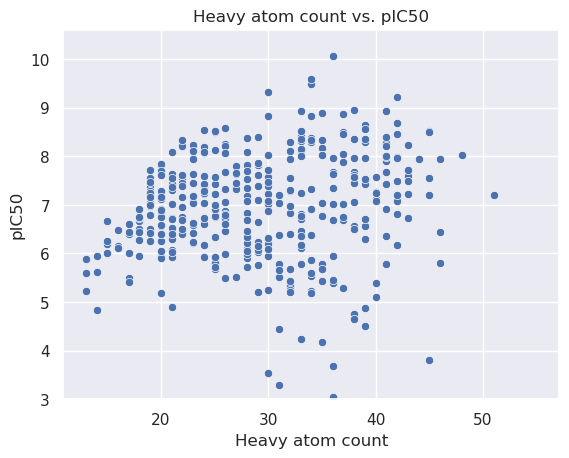

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem.Descriptors import HeavyAtomCount

sns.set()
sns.scatterplot(
    x=[HeavyAtomCount(m.mol) for m in library],
    y=docking_oracle(library),
)

plt.xlabel('Heavy atom count')
plt.ylabel('pIC50')
plt.title('Heavy atom count vs. pIC50')
plt.ylim(3)

<Figure size 1920x1440 with 0 Axes>

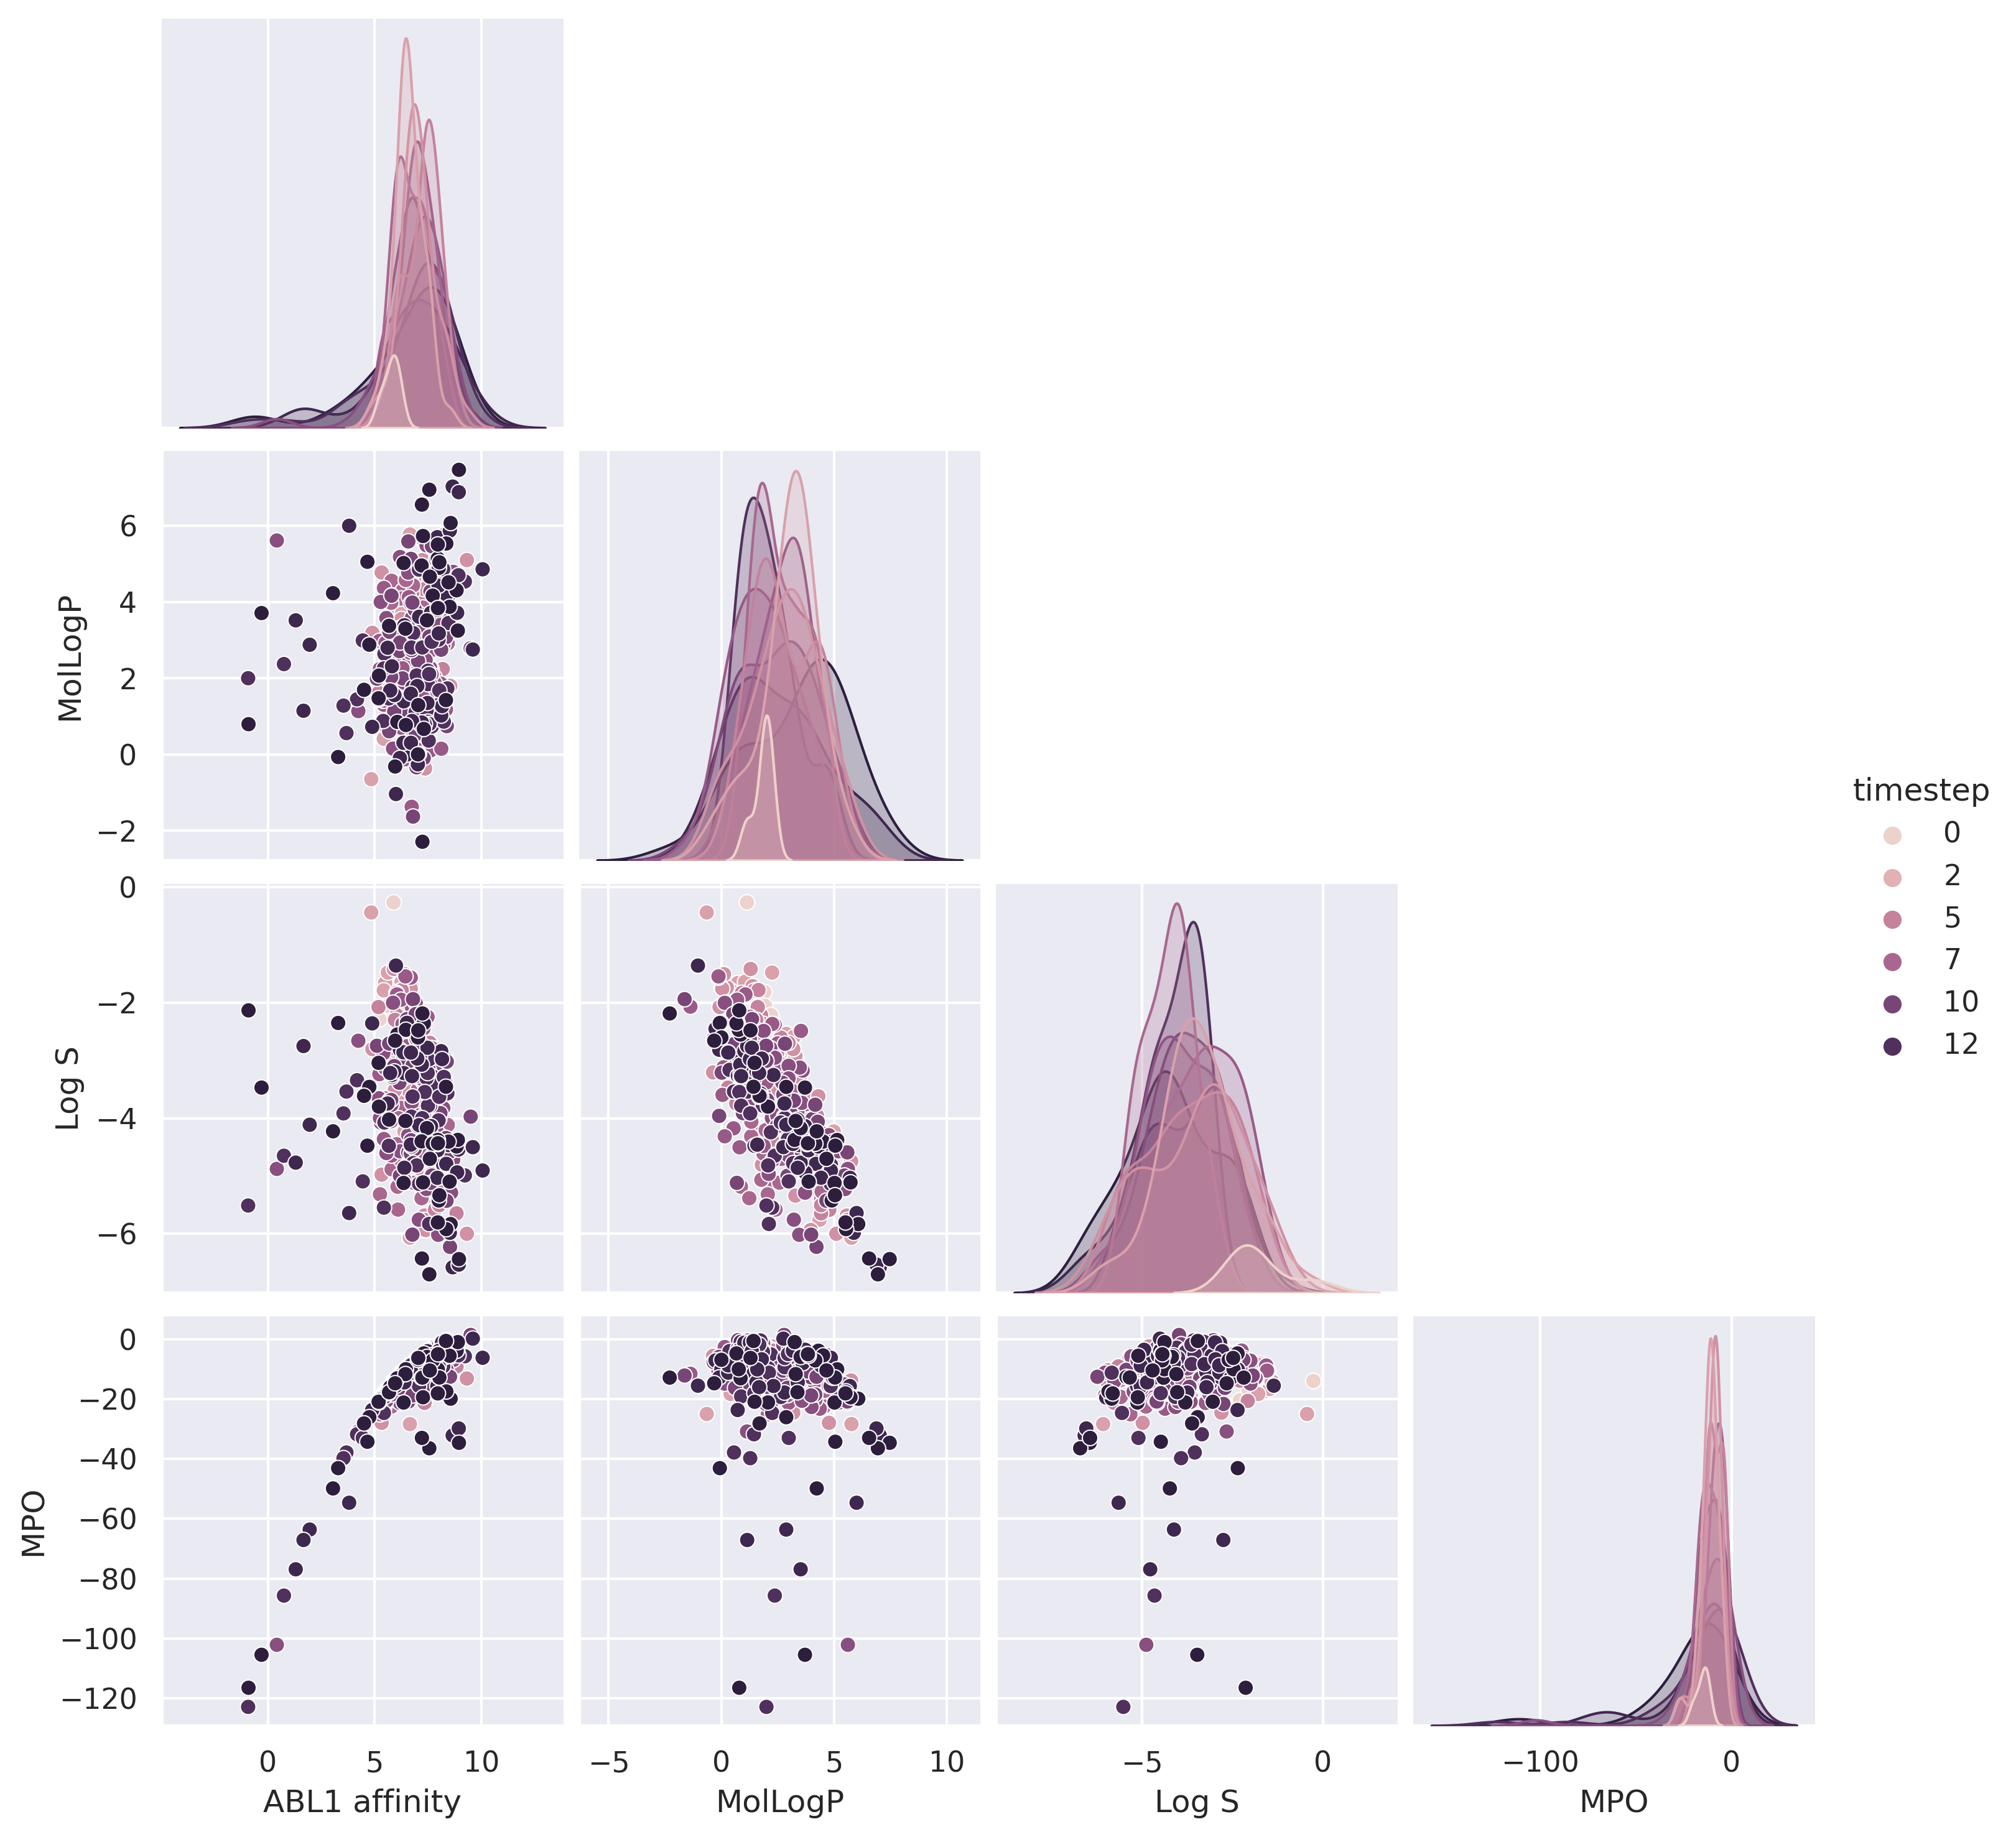

In [155]:
import pandas as pd

plt.figure(dpi=300)

pairplot_df = (
    library.annotations[
        ['ABL1 affinity', 'MolLogP', 'Log S', 'timestep']
    ].map(
        lambda x: x[0] if isinstance(x, list) else x
    ).dropna()
)

pairplot_df['MPO'] = np.zeros(len(pairplot_df))
for i, utility_function in enumerate(utility_functions):
    pairplot_df['MPO'] += pairplot_df.iloc[:,i].apply(utility_function)

sns.set_theme()
g = sns.pairplot(
    pairplot_df,
    corner=True,
    hue='timestep'
)
g.fig.set_dpi(300)

## Visualizing the best across rounds

A trajectory of the best molecule each round.

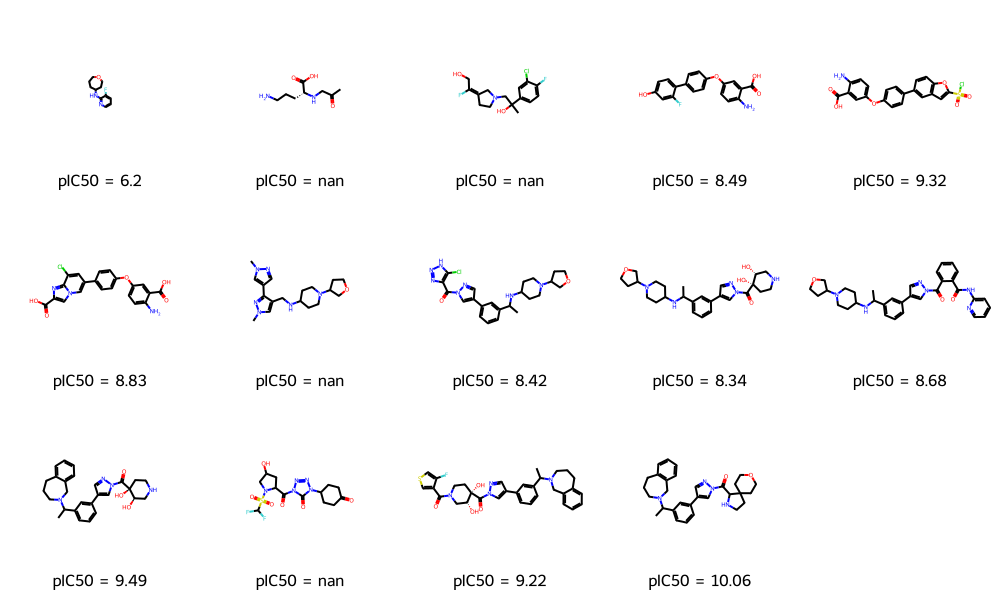

In [156]:
best_across_round = [
    library.annotations.query(f'timestep == {i}')[f'{name} affinity']
    .sort_values(na_position='first')
    .index[-1].item()
    for i in range(int(library.annotations.timestep.max()))
    if library.annotations.query(f'timestep == {i}')[f'{name} affinity'].any()
]

from rdkit.Chem.Draw import MolsToGridImage

get_affinity = lambda idx: library[idx][f'{name} affinity'][0]
MolsToGridImage(
    [m.mol for m in library[best_across_round]],
    molsPerRow=5,
    legends=[f'pIC50 = {round(get_affinity(b), 2)}' for b in best_across_round]
)

A trajectory of the best molecule.

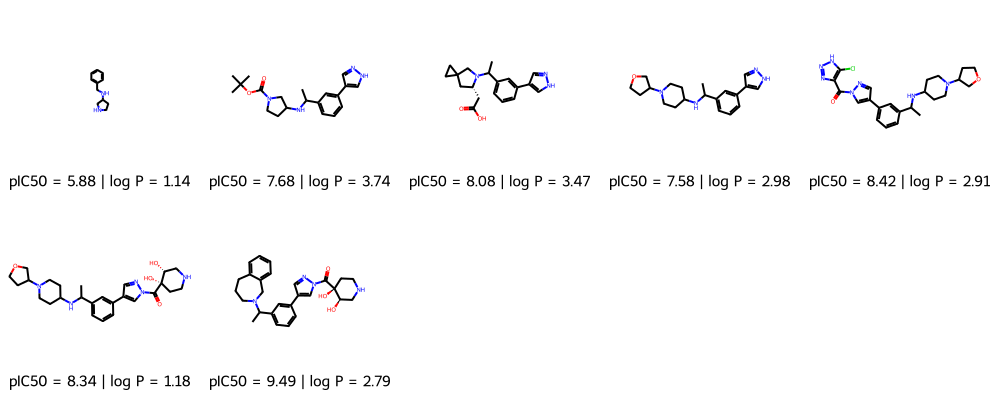

In [157]:
# mol = library[np.nanargmax(docking_oracle(library)).item()]
mol = library[best[0]]
milestones = [mol]
while mol.inspiration:
    milestones.append(mol.inspiration)
    mol = mol.inspiration
    
milestones = list(reversed(milestones))
MolsToGridImage(
    [m.mol for m in milestones],
    molsPerRow=5,
    legends=[f'pIC50 = {round(docking_oracle(m)[0], 2)} | log P = {round(log_P_oracle(m)[0], 2)}' for m in milestones]
)

Text(0.5, 1.0, 'New compounds synthesized each round')

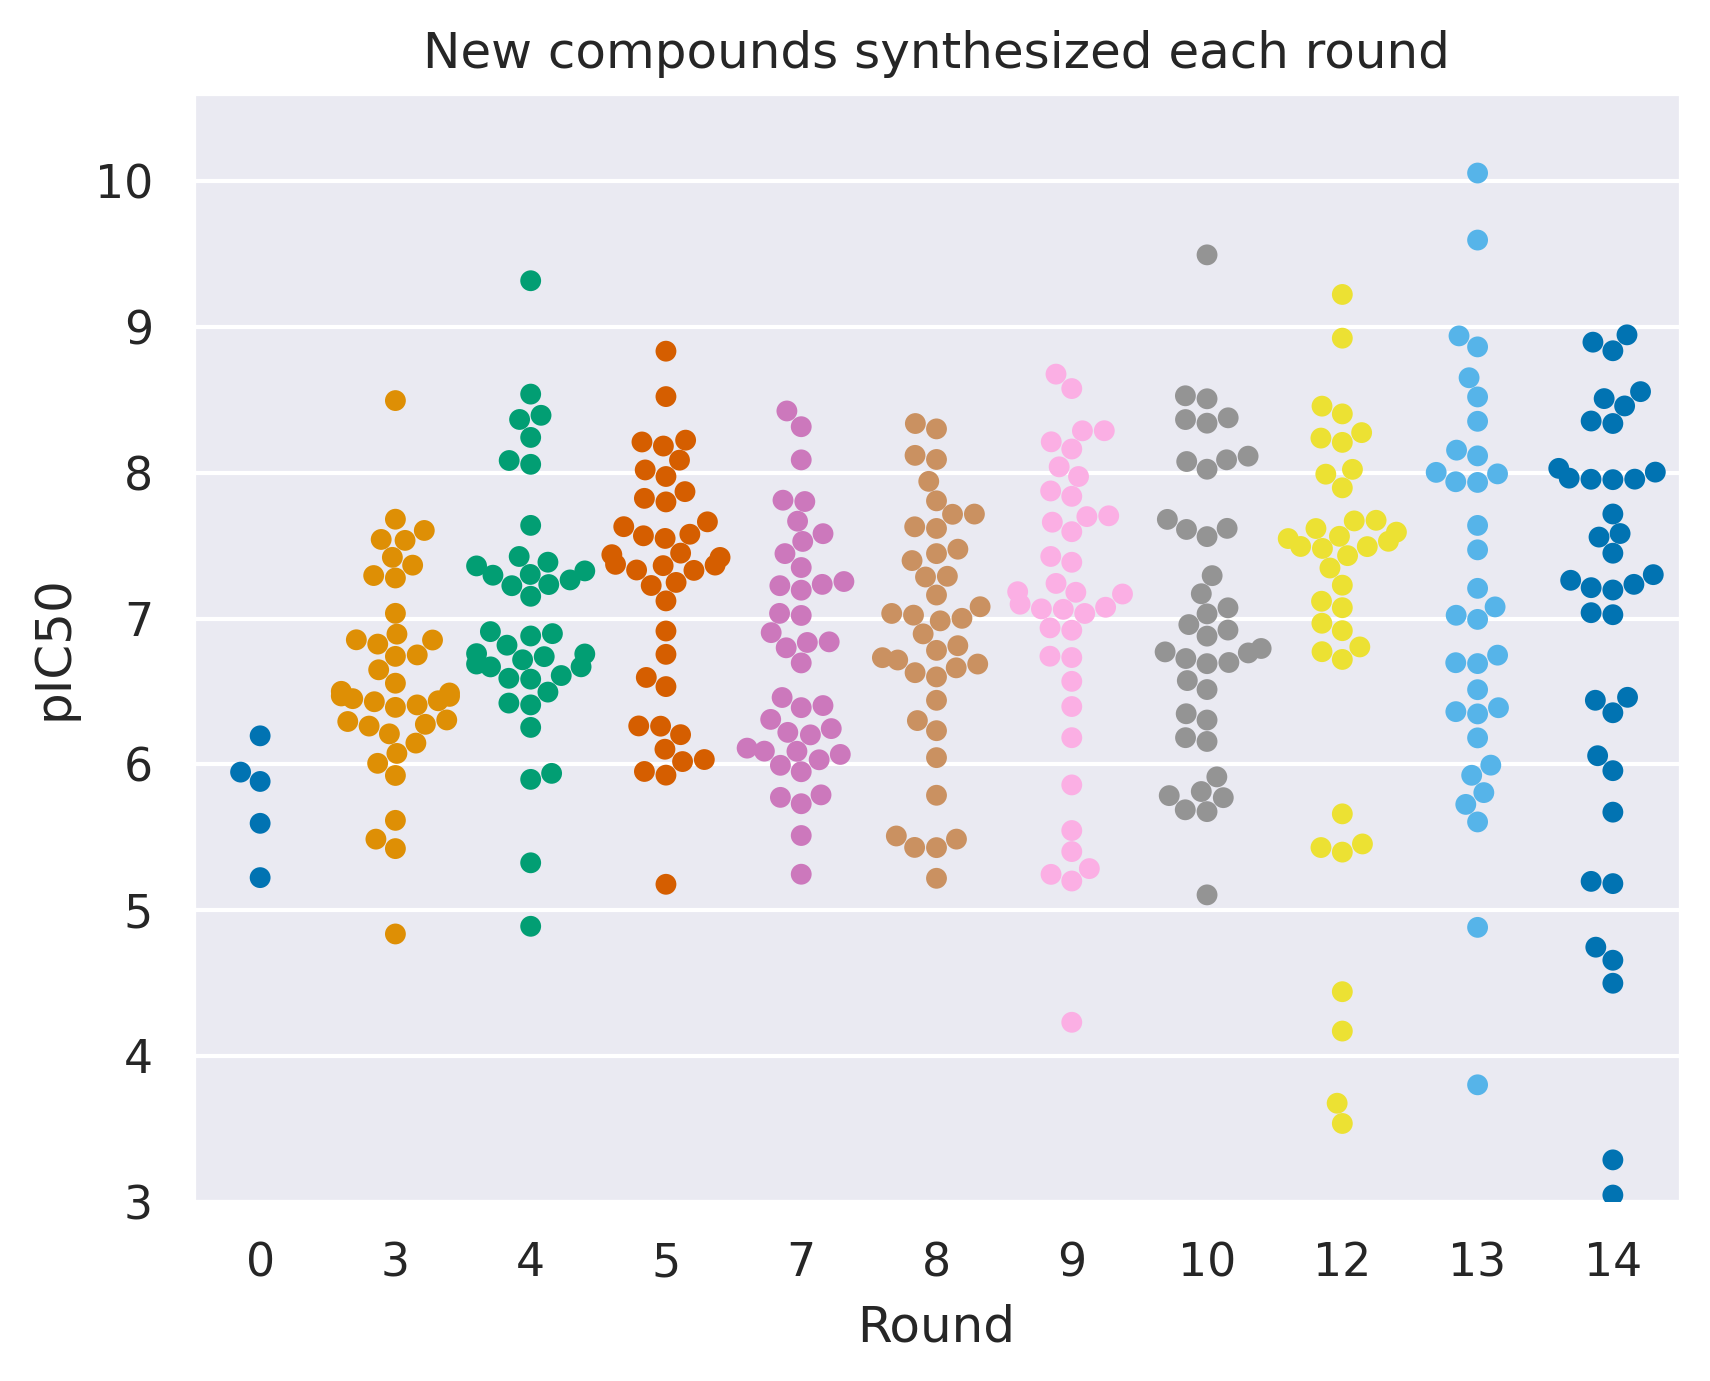

In [158]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(dpi=300)
sns.set()

objective = f'{name} affinity'

sns.swarmplot(
    pairplot_df,
    x='timestep',
    y=objective,
    hue='timestep',
    palette='colorblind',
    # complementary=True,
    legend=False
)

plt.ylim(3)
plt.ylabel('pIC50')
plt.xlabel('Round')
plt.title('New compounds synthesized each round')

In [159]:
max_timestep = int(library.annotations.timestep.max())

records = []
for timestep, group in pairplot_df.groupby('timestep'):
    for _, mol in group.iterrows():
        record = {
            'pIC50': mol[objective], 'timestep': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'timestep': t})

df = pd.DataFrame(records)

Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

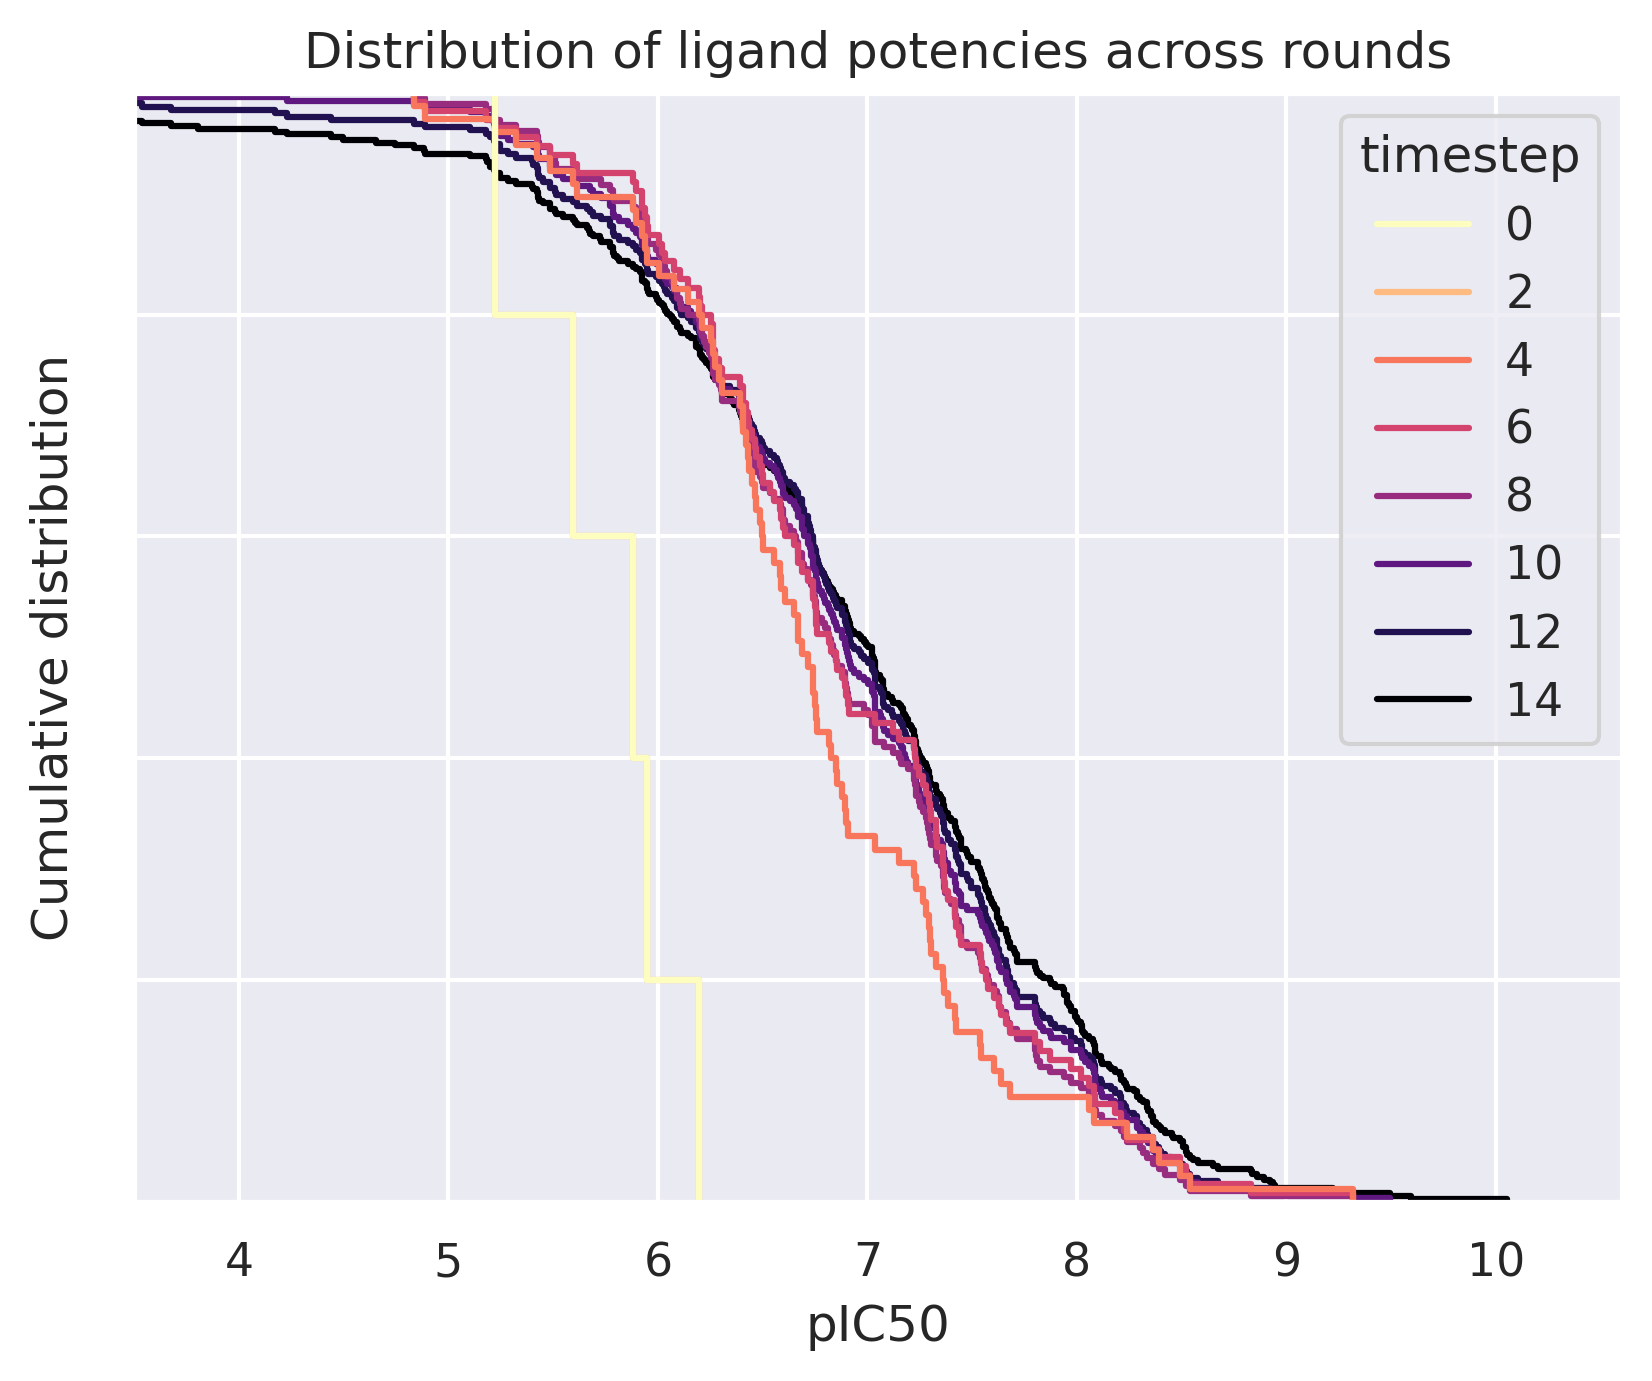

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(dpi=300)

g = sns.ecdfplot(
    df.query('timestep % 2 == 0'),
    x='pIC50',
    hue='timestep',
    palette='magma_r',
    complementary=True
)

g.set(yticklabels=[])

plt.xlim(3.5)
plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')

Text(0.5, 1.0, 'Assay values across time')

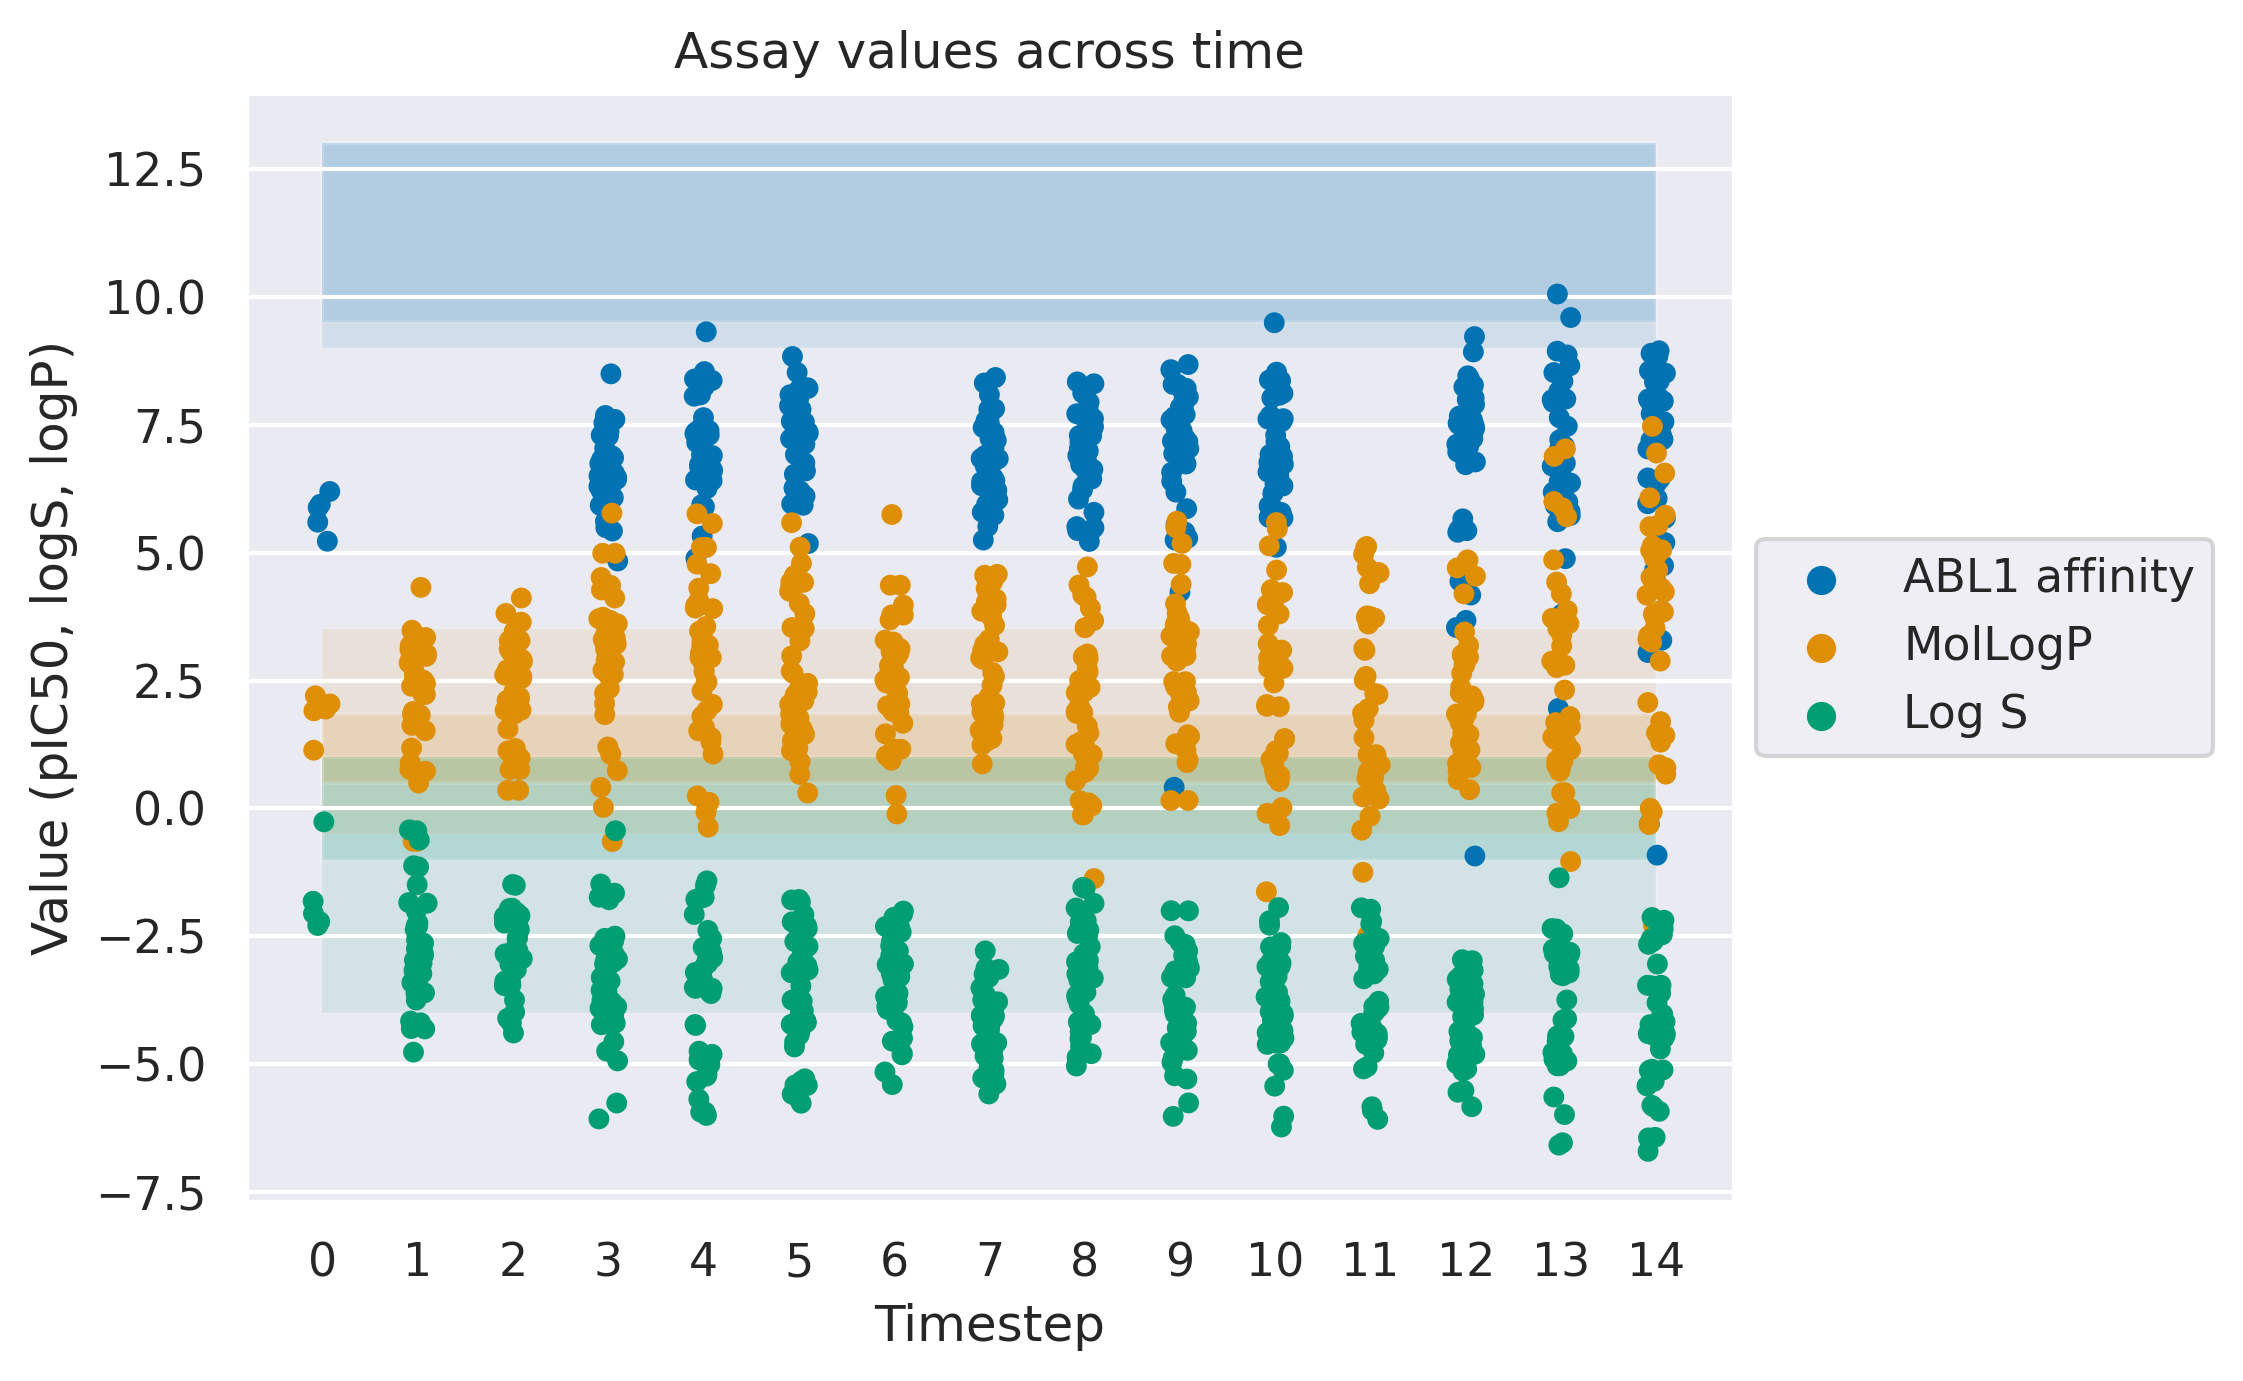

In [162]:
plt.figure(dpi=300)
sns.set_theme()

annotations = (
    library.annotations
    .map(lambda x: x[0] if isinstance(x, list) else x)
    [['timestep', f'{name} affinity', 'MolLogP', 'Log S']]
)

annotations = pd.melt(
    annotations,
    id_vars=['timestep'],
    var_name='assay',
    value_name='value'
)

g = sns.stripplot(
    annotations,
    x='timestep',
    y='value',
    hue='assay',
    palette='colorblind'
)

plt.fill_betweenx(
    log_S_utility_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[2]
)
plt.fill_betweenx(
    log_P_utility_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[1]
)
plt.fill_betweenx(
    docking_utility_function.acceptable, 0, annotations.timestep.max(), alpha=0.1, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[0]
)

plt.fill_betweenx(
    log_S_utility_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[2]
)
plt.fill_betweenx(
    log_P_utility_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[1]
)
plt.fill_betweenx(
    docking_utility_function.ideal, 0, annotations.timestep.max(), alpha=0.15, zorder=-10,
    facecolor=sns.palettes.color_palette('colorblind')[0]
)

g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Timestep')
plt.ylabel('Value (pIC50, logS, logP)')
plt.title('Assay values across time')

In [163]:
results = docking_oracle(
    [library[best[0]]]*10, use_cache=False)

In [148]:
np.std(
 [8.258676577323012, 9.221355432276672, 8.911614026575538])

0.4012504937784432

In [122]:
results

[7.405042212392383,
 7.405042212392383,
 7.405042212392383,
 7.405042212392383,
 7.405042212392383,
 7.405042212392383,
 7.405042212392383,
 7.405042212392383,
 7.405042212392383,
 7.405042212392383]

In [178]:
docking_oracle(library[best[0]].lineage[0])

[5.882460587196079]

In [185]:
[u(library[best[0]])[0] for u in assays]

[9.493986795149752, 2.785000000000001, -3.972658217012141]

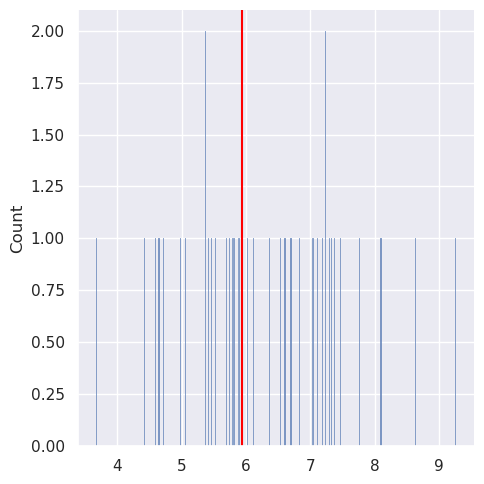

In [283]:
designer.reset()

starting_molecule = initial_library[0] # library[best[0]]
analogs = designer.design(
    starting_molecule, 40, temperature=1.0)
results = docking_oracle(
    analogs, use_cache=False)
sns.displot(results, bins=300)
plt.axvline(
    docking_oracle(starting_molecule), color='red')

Text(0.5, 1.0, 'Great molecules are difficult to improve (top right is best)')

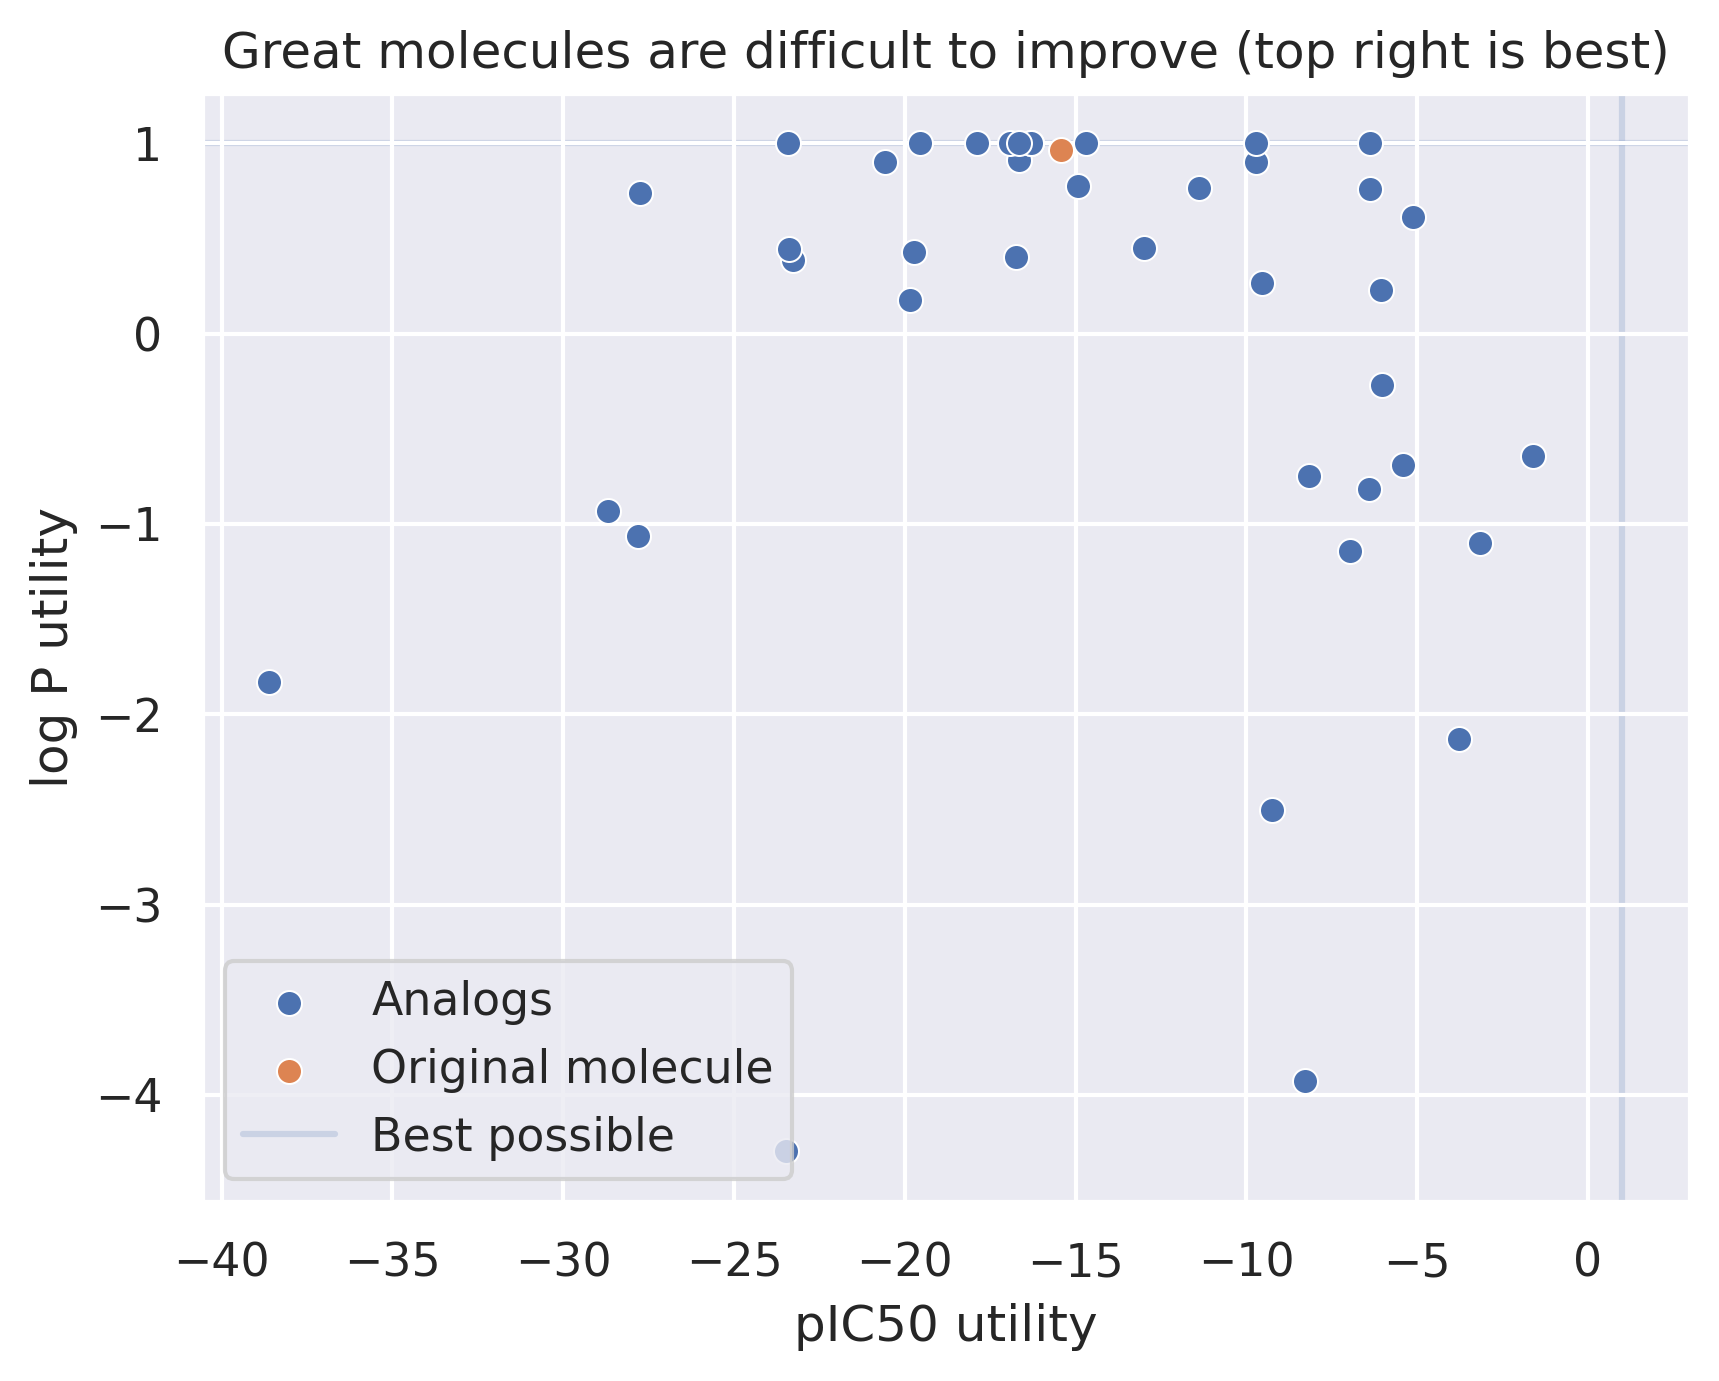

In [286]:
plt.figure(dpi=300)
g = sns.scatterplot(
    x=utility_functions[0](analogs), y=utility_functions[1](analogs),
    label='Analogs'
)
sns.scatterplot(
    x=[utility_functions[0](starting_molecule)], y=[utility_functions[1](starting_molecule)],
    label='Original molecule'
)

plt.axhline(1, alpha=0.2, zorder=-10)
plt.axvline(1, alpha=0.2, zorder=-10, label='Best possible')
plt.legend(loc='lower left')
plt.xlabel('pIC50 utility')
plt.ylabel('log P utility')
plt.title('Great molecules are difficult to improve (top right is best)')

In [189]:
np.nanargmax(results)

20

In [192]:
docking_oracle(analogs[20])

[9.731378202160117]

In [196]:
pd.DataFrame([u(analogs) for u in assays]).T

,0,1,2
0,9.393506,6.41860,-5.698087
1,9.907866,4.98450,-5.560873
2,6.483085,0.87510,-2.918640
3,8.616366,5.89070,-5.455792
4,7.743284,0.74970,-2.943055
5,5.809585,3.26460,-3.040560
6,9.694414,5.23830,-5.392240
7,9.284357,6.66430,-6.341156
8,8.685515,5.29070,-4.872480
9,9.767928,4.95890,-5.844950


In [118]:
library[best[0]].dump()

{'product': 'Cn1nc(C(=O)N2CCC(C(=O)N3CCc4ccccc43)CC2)c(O)c1C(=O)N1CCc2ccccc21',
 'reaction': '13_Carboxylate_and_Amine',
 'reactants': [{'product': 'Cn1nc(C(=O)O)c(O)c1C(=O)N1CCc2ccccc21',
   'reaction': '83_Schotten_Baumann_amide',
   'reactants': [{'product': 'c1ccc2c(c1)CCN2'},
    {'product': 'Cn1nc(C(=O)O)c(O)c1C(=O)O'}]},
  {'product': 'Cl.O=C(C1CCNCC1)N1CCc2ccccc21'}]}

In [80]:
analogs[np.argsort(results)[-3]].dump()

{'product': 'O=C1OC[C@@]23CC[C@@H](O2)[C@@H](C(=O)n2ccn(-c4ccc(C(=O)N5CC[C@@H]6CCNC[C@@H]6C5=O)cc4)c2=O)[C@@H]13',
 'reaction': '13_Carboxylate_and_Amine',
 'reactants': [{'product': 'O=C(c1ccc(-n2cc[nH]c2=O)cc1)N1CC[C@@H]2CCNC[C@@H]2C1=O',
   'reaction': '13_Carboxylate_and_Amine',
   'reactants': [{'product': 'O=C(O)c1ccc(-n2cc[nH]c2=O)cc1'},
    {'product': 'Cl.O=C1NCC[C@@H]2CCNC[C@H]12'}]},
  {'product': 'O=C(O)[C@H]1[C@H]2C(=O)OC[C@]23CC[C@H]1O3'}]}

In [78]:
best_analog = analogs[np.argsort(results)[-3]]
[u(best_analog)[0] for u in assays]

[9.282388751109156, 0.5980000000000008, -3.678984195619255]

In [55]:
docking_oracle(library[best[0]])

[9.252554294064991]

In [167]:
# from radar import radar_chart
# import matplotlib.pyplot as plt

# annotations = (
#     library.annotations.map(
#     lambda x: x[0] if isinstance(x, list) else x)
#     [['CASP3 affinity', 'MolLogP', 'Log S']]
# )

# labels = annotations.columns
# values = annotations.iloc[0]

# radar_chart(
#     labels=labels, values=values, fill_alpha=0)
# plt.show()

Docking on-disk.

In [168]:
results = docking_oracle(
    milestones,
    # path='../../dgym-data/out/docking_results',
    use_cache=False
)
results

[5.414583693778528,
 7.619178138277572,
 8.464572469784313,
 7.230776040265723,
 7.508294157316174,
 9.545399596310647]

In [169]:
docking_oracle(milestones)

[5.296790820592244,
 7.852951762053853,
 8.485377189191793,
 8.379315411720343,
 8.450697222951833,
 9.980465899262242]

## Manual selection experiments

In [307]:
[c(library[best]) for c in cost_functions]

[array([0.91376542, 1.30816624, 1.59607717, 0.93885823, 0.51481126]),
 array([0.        , 0.22036364, 0.        , 0.64957576, 0.84745455]),
 array([0.94758702, 0.79207573, 0.83260036, 0.85939413, 1.14689711])]

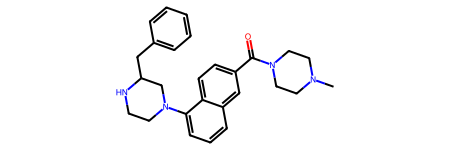

In [190]:
library[best][4]

In [733]:
mol = next(designer.construct_reaction({'product': 'O=C(c1ccc([C@@H]2Nc3c(Cl)cc(Cl)cc3[C@@H]3C=CC[C@@H]32)cc1)N1CC2C(C1)C(F)(F)C(F)(F)C(F)(F)C2(F)F',
 'reaction': '83_Schotten_Baumann_amide',
 'reactants': [{'product': 'Cl.FC1(F)C2CNCC2C(F)(F)C(F)(F)C1(F)F'},
  {'product': 'O=C(O)c1ccc([C@@H]2Nc3c(Cl)cc(Cl)cc3[C@@H]3C=CC[C@@H]32)cc1'}]}))

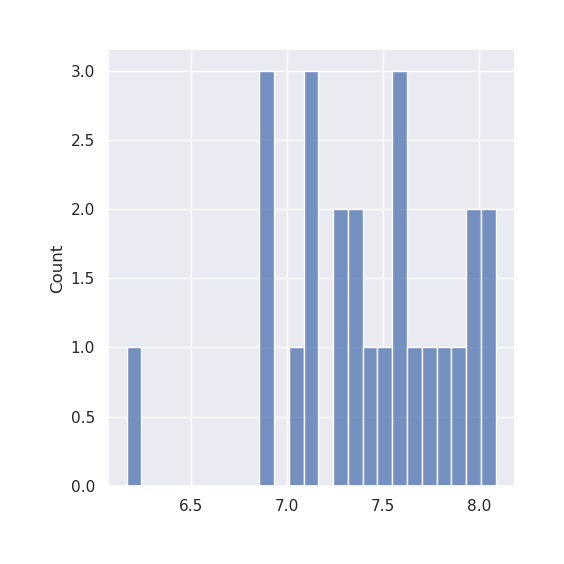

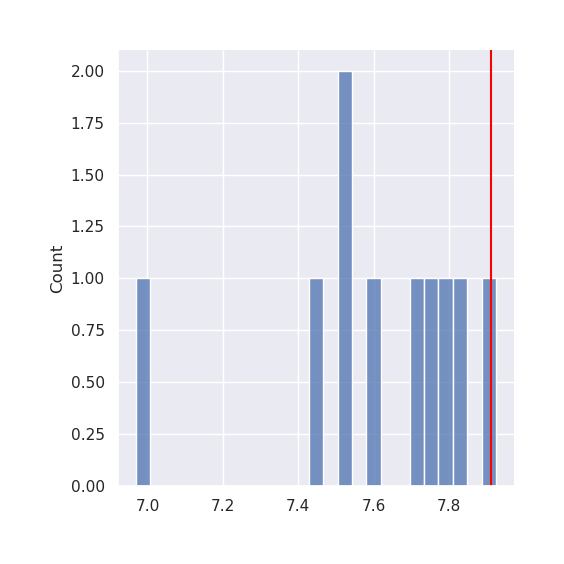

In [852]:
starting_point = library[477]
starting_point_replicates = docking_oracle([starting_point]*10, use_cache=False)

analogs = designer.design(
    starting_point, 25, strategy='replace', temperature=0.0)
analog_docking_scores = docking_oracle(analogs, use_cache=False)

sns.displot(analog_docking_scores, bins=25)
sns.displot(starting_point_replicates, bins=25)
plt.axvline(docking_oracle(library[477]), color='red')

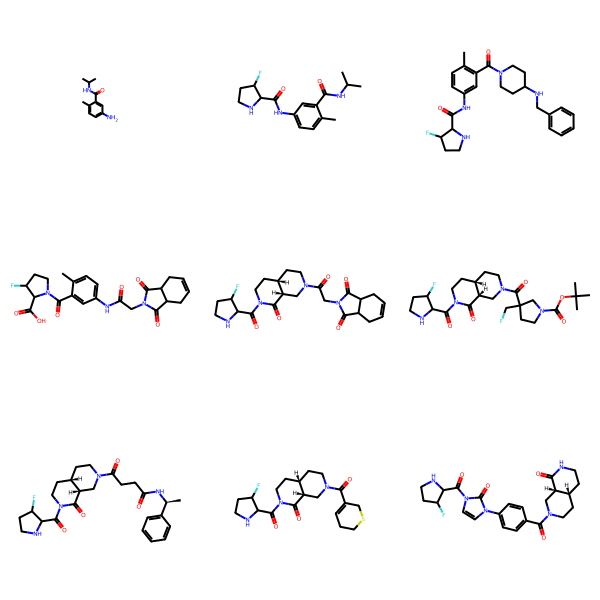

In [183]:
MolsToGridImage([l.mol for l in library[best[0]].lineage])

In [117]:
import tabulate
data = [["Sun",696000,1989100000],
         ["Earth",6371,5973.6],
         ["Moon",1737,73.5],
         ["Mars",3390,641.85]]

table = tabulate.tabulate(data, tablefmt='html')
table

Sun,696000,1.9891e+09
Earth,6371,5973.6
Moon,1737,73.5
Mars,3390,641.85
